In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [12]:
from read_data import load_df
import numpy as np

In [64]:
from jupyterthemes import jtplot
jtplot.style()

In [13]:
df = load_df()
values = df.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [20]:
df.groupby(df.index)['SalePrice'].rank?

Object `rank` not found.


In [35]:
sales_price = df[['SalePrice']]

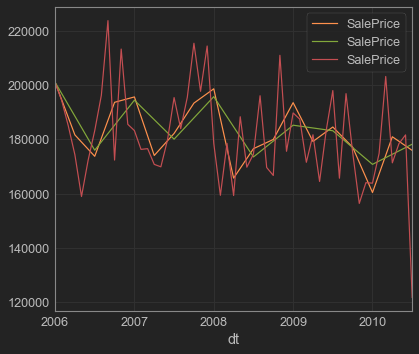

In [69]:
df.SalePrice.resample('3M').mean().plot(color='y', legend=True)
df.SalePrice.resample('6M').mean().plot(color='g', legend=True)
df.SalePrice.resample('M').mean().plot(color='r', legend=True)
plt.show()

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [5]:
df_target = pd.DataFrame(scaled)

In [70]:
reframed = series_to_supervised(scaled, 5)
print reframed.shape
# split into train and test sets
values = reframed.values
n_train_time = int(reframed.shape[0]*0.9)

(1455, 1386)


In [71]:
train = values[:n_train_time, :]
test = values[n_train_time:, :]

In [72]:
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

((1309, 1, 1385), (1309,), (146, 1, 1385), (146,))


In [74]:
model = Sequential()
model.add(LSTM(300, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_x, train_y, epochs=120, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=True)

Train on 1309 samples, validate on 146 samples
Epoch 1/120
 - 2s - loss: 0.1870 - val_loss: 0.0139
Epoch 2/120
 - 1s - loss: 0.0202 - val_loss: 0.0119
Epoch 3/120
 - 1s - loss: 0.0103 - val_loss: 0.0097
Epoch 4/120
 - 1s - loss: 0.0081 - val_loss: 0.0085
Epoch 5/120
 - 1s - loss: 0.0066 - val_loss: 0.0071
Epoch 6/120
 - 1s - loss: 0.0057 - val_loss: 0.0062
Epoch 7/120
 - 1s - loss: 0.0047 - val_loss: 0.0055
Epoch 8/120
 - 1s - loss: 0.0039 - val_loss: 0.0050
Epoch 9/120
 - 1s - loss: 0.0033 - val_loss: 0.0046
Epoch 10/120
 - 1s - loss: 0.0031 - val_loss: 0.0043
Epoch 11/120
 - 1s - loss: 0.0028 - val_loss: 0.0041
Epoch 12/120
 - 1s - loss: 0.0023 - val_loss: 0.0040
Epoch 13/120
 - 1s - loss: 0.0022 - val_loss: 0.0037
Epoch 14/120
 - 1s - loss: 0.0019 - val_loss: 0.0036
Epoch 15/120
 - 1s - loss: 0.0019 - val_loss: 0.0035
Epoch 16/120
 - 1s - loss: 0.0017 - val_loss: 0.0034
Epoch 17/120
 - 1s - loss: 0.0016 - val_loss: 0.0033
Epoch 18/120
 - 1s - loss: 0.0014 - val_loss: 0.0033
Epoch 19

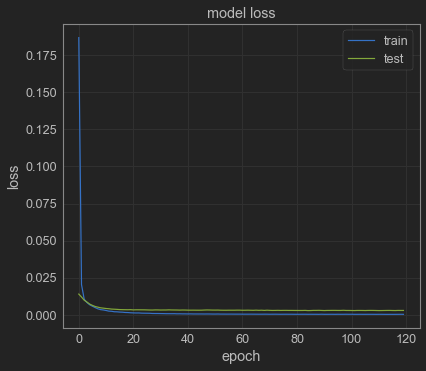

In [75]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [81]:
# make a prediction
predictions = model.predict(test_x)

RMSE is: 0.002800657205416437


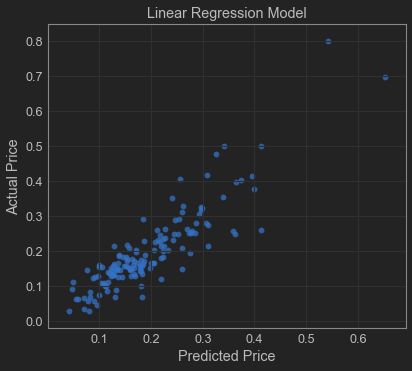

In [80]:
print 'RMSE is:', mean_squared_error(test_y , predictions)
plt.scatter(predictions, test_y, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

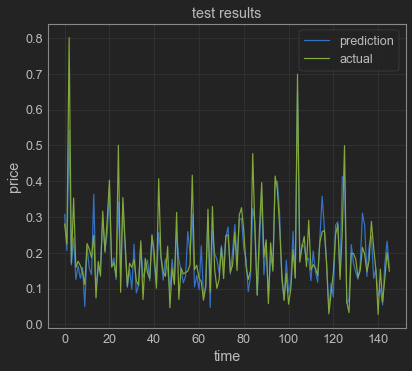

In [82]:
plt.plot(predictions)
plt.plot(test_y)
plt.title('test results')
plt.ylabel('price')
plt.xlabel('time')
plt.legend(['prediction', 'actual'], loc='upper right')
plt.show()